<a href="https://colab.research.google.com/github/alexlimatds/text_classification_notebooks/blob/master/finance_complaints_fast_ai_ULMFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finance complaints classification with ULMFit and Fast.ai.
Reference pages:
- https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb

The dataset was preprocessed in **finance complaints dataset analysis** notebook.

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Doutorado/finance complaints experiment'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%matplotlib inline

In [0]:
from fastai.text import *

## Preparing the data

In [0]:
path = Path(base_dir)
path.ls()

[PosixPath('/content/gdrive/My Drive/Doutorado/finance complaints experiment/complaints-balanced.csv'),
 PosixPath('/content/gdrive/My Drive/Doutorado/finance complaints experiment/classification results.gsheet')]

In [0]:
df = pd.read_csv(path/'complaints-balanced.csv')
df.head()

,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",My XXXX XXXX Account Was Paid Off But They Hav...,0
1,1,"Credit reporting, credit repair services, or o...",I had a citibank checking account which I clos...,0
2,2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,0
3,3,"Credit reporting, credit repair services, or o...",Account from XXXX with a balance is reporting ...,0
4,4,"Credit reporting, credit repair services, or o...",The credit bureaus are reporting inaccurate/ou...,0


In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

text = df.Consumer_complaint_narrative
label = df.Product
sss = StratifiedShuffleSplit(n_splits=1, 
                             test_size=0.3, 
                             random_state=0)
for train_index, test_index in sss.split(text, label):
  train = df.loc[train_index]
  validation = df.loc[test_index]

**Language Model**

In [0]:
doc(TextLMDataBunch.from_df)

The following code will prepare the data to the Language Model. It performs tokenization and numericalization of the input text.

In [0]:
%%time
data_lm = TextLMDataBunch.from_df(path, 
                                train_df=train, 
                                valid_df=validation, 
                                text_cols='Consumer_complaint_narrative')

CPU times: user 522 ms, sys: 170 ms, total: 692 ms
Wall time: 5.29 s


In [0]:
def print_example(index):
  print("-"*50)
  print("\n{}\n".format(data_lm.train_ds[index][0]))

print_example(0)
print_example(10)
print_example(50)

--------------------------------------------------

xxbos xxmaj sorry for the xxunk of this ! xxmaj accidentally , i filed a complaint on xxrep 4 x xxrep 4 x , xxrep 4 x with the wrong agency ( xxmaj federal xxmaj trade xxmaj commission , ref # xxrep 4 x ) . xxmaj below was what i sent to them : xxmaj on xxrep 4 x xxrep 4 x , xxrep 4 x , i purchased from xxmaj best xxmaj xxunk an xxrep 4 x xxrep 4 x xxrep 4 x xxrep 4 x and the extra protection insurance plan , xxrep 8 x xxrep 4 x xxrep 4 x for xxrep 4 x . xxmaj the cost of this insurance plan is $ xxrep 4 x mth , and it is automatically deducted from my account each month . xxmaj on xxup xx / xxup xx / xxrep 4 x i had to change my xxmaj best xxmaj buy credit card # as a family member was racking up charges on it ! i did xxup nothing to the account other than change the # . xxmaj and now here is where xxmaj best xxmaj buy xxunk : i guess when i changed my account # 's on xxup xx / xxup xx / xxrep 4 x , on my xxrep 4 x statement the { $ 

Fine tuning the pre-trained language model.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Finding the learning rate value.

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02
Min loss divided by 10: 3.02E-02


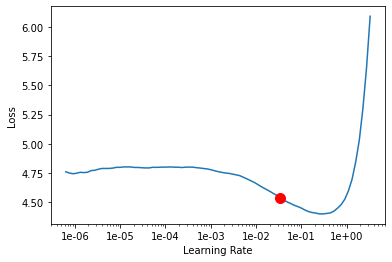

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(1, 4.79e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.458839,3.248498,0.373379,00:33


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head')
learn.unfreeze()

In [0]:
learn.fit_one_cycle(3, 4.79e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.988126,3.116501,0.388358,00:43
1,2.731730,2.952306,0.416089,00:43
2,2.166058,2.981882,0.420251,00:43


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state.

In [0]:
learn.save_encoder('fine_tuned_enc')

**Classifier**

The following code will prepare the data to the Text classifier.

In [0]:
doc(TextClasDataBunch.from_df)

In [0]:
%%time
data_clas = TextClasDataBunch.from_df(path, 
                                train_df=train, 
                                valid_df=validation, 
                                text_cols='Consumer_complaint_narrative', 
                                label_cols='category_id', 
                                vocab=data_lm.train_ds.vocab)

CPU times: user 620 ms, sys: 175 ms, total: 795 ms
Wall time: 5.38 s


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (2516 items)
x: TextList
xxbos xxmaj sorry for the xxunk of this ! xxmaj accidentally , i filed a complaint on xxrep 4 x xxrep 4 x , xxrep 4 x with the wrong agency ( xxmaj federal xxmaj trade xxmaj commission , ref # xxrep 4 x ) . xxmaj below was what i sent to them : xxmaj on xxrep 4 x xxrep 4 x , xxrep 4 x , i purchased from xxmaj best xxmaj xxunk an xxrep 4 x xxrep 4 x xxrep 4 x xxrep 4 x and the extra protection insurance plan , xxrep 8 x xxrep 4 x xxrep 4 x for xxrep 4 x . xxmaj the cost of this insurance plan is $ xxrep 4 x mth , and it is automatically deducted from my account each month . xxmaj on xxup xx / xxup xx / xxrep 4 x i had to change my xxmaj best xxmaj buy credit card # as a family member was racking up charges on it ! i did xxup nothing to the account other than change the # . xxmaj and now here is where xxmaj best xxmaj buy xxunk : i guess when i changed my account # 's on xxup xx / xxup xx / xxrep 4 x , on my xx

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-03
Min loss divided by 10: 7.59E-02


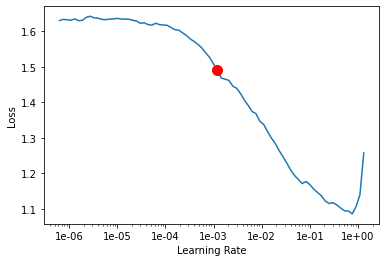

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(1, 1.2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.980251,0.905502,0.773865,00:27


In [0]:
learn.save('first')

In [0]:
learn.load('first');
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1.2e-3/(2.6**4),1.2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.713189,0.520186,0.829472,00:27


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-4/(2.6**4),5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.613407,0.496908,0.846154,00:40


In [0]:
learn.save('third')

In [0]:
learn.load('third')
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.564966,0.464684,0.851715,00:44
1,0.537835,0.446245,0.853568,00:51
2,0.464966,0.444174,0.853568,00:45
3,0.414961,0.434668,0.858202,00:49
